In [1]:
# For this project, we are given some data gathered about various features of forests. Each data row represents a 30x30
# meter area of forest and several relevant features that correspond to that area.

# For each data point, 12 characteristics of that area of forest were gathered:
# -Elevation in meters
# -Aspect: the direction of the slope in degrees azimuth (0-359)
# -Slope: in degrees
# -Horizontal_Distance_To_Hydrology: in meters
# -Vertical_Distance_To_Hydrology: in meters
# -Horizontal_Distance_To_Roadways: in meters
# -Hillshade_9am: from 0-255
# -Hillshade_noon: from 0-255
# -Hillshade_3pm: from 0-255
# -Horizontal_Distance_To_Fire_Points: in meters
# -Wilderness_Area: categorical feature for 4 different wilderness areas (Rawah, Neota, Comanche Peak, Cache la Poudre).
#      Luckily, broken out into a 40-feature one-hot encoding for us already.
# -Soil_Type: categorical for 40 different soil types. Luckily, broken out into a 40-feature one-hot encoding for us
#      already.
# -Cover_Type: categorical for 7 different cover types (spruce/fir, lodgepole pine, ponderosa pine, cottonwood/willow,
#      aspen, douglas-fir, krummholz)

# Our task is to try and determine the cover type from the other features given.

In [2]:
import pandas                  as pd
import math
import numpy                   as np

import sklearn.preprocessing   as sklpp
import sklearn.decomposition   as skldecomp
import sklearn.model_selection as sklms
import sklearn.tree            as skltr
import sklearn.svm             as sklsvm
import sklearn.naive_bayes     as sklnb
import sklearn.multiclass      as sklmc
import sklearn.linear_model    as skllm
import sklearn.neural_network  as sklnn

import keras.models            as km
import keras.layers            as kl
import keras.callbacks         as kc

import matplotlib.pyplot       as plt

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open('covtype.info', 'r') as f:
    for line in f.readlines():
        print(line[:-1])

The Forest CoverType dataset


1.	Title of Database:

	Forest Covertype data


2.	Sources:

	(a) Original owners of database:
		Remote Sensing and GIS Program
		Department of Forest Sciences
		College of Natural Resources
		Colorado State University
		Fort Collins, CO  80523
		(contact Jock A. Blackard, jblackard 'at' fs.fed.us
		      or Dr. Denis J. Dean, denis.dean 'at' utdallas.edu)

	NOTE:	Reuse of this database is unlimited with retention of 
		copyright notice for Jock A. Blackard and Colorado 
		State University.

	(b) Donors of database:
		Jock A. Blackard (jblackard 'at' fs.fed.us)
		GIS Coordinator
		USFS - Forest Inventory & Analysis
		Rocky Mountain Research Station
		507 25th Street
		Ogden, UT 84401

		Dr. Denis J. Dean (denis.dean 'at' utdallas.edu)
		Professor
		Program in Geography and Geospatial Sciences
		School of Economic, Political and Policy Sciences
		800 West Campbell Rd
		Richardson, TX  75080-3021 
		
		Dr. Charles W. Anderson (anderson 'at' cs.colostate.edu

In [4]:
data = pd.read_csv('covtype.data')
# Was running slow with all ~600k data points, so pare it down. That should still be fine.
data = data.sample(frac = 0.05, random_state = 200)
data

,elevation,aspect,slope,dist_to_hydro_horiz,dist_to_hydro_vert,dist_to_road_horiz,hillshade_9am,hillshade_noon,hillshade_3pm,dist_to_fire_horiz,...,soil_type_7756,soil_type_7757,soil_type_7790,soil_type_8703,soil_type_8707,soil_type_8708,soil_type_8771,soil_type_8772,soil_type_8776,covertype
67232,3031,0,5,741,66,5671,213,231,156,5810,...,0,0,0,0,0,0,0,0,0,2
187758,3180,0,3,402,77,4119,215,234,156,987,...,0,0,0,0,0,0,0,0,0,2
205893,3238,75,13,430,89,4214,235,216,110,1188,...,0,0,0,0,0,0,0,0,0,2
265094,2063,329,31,67,47,270,131,186,186,404,...,0,0,0,0,0,0,0,0,0,6
89668,2968,251,12,534,65,5736,193,248,193,3684,...,0,0,0,0,0,0,0,0,0,2
528948,3264,328,19,421,113,2873,170,214,182,551,...,0,1,0,0,0,0,0,0,0,1
559457,2617,18,9,42,2,3391,213,221,144,2765,...,0,0,0,0,0,0,0,0,0,1
344516,2816,104,4,175,15,1239,226,234,143,1959,...,0,0,0,0,0,0,0,0,0,2
82863,2991,90,9,247,29,3275,233,227,125,6187,...,0,0,0,0,0,0,0,0,0,2
14848,2682,163,18,242,47,3197,234,242,131,1838,...,0,0,0,0,0,0,0,0,0,5


In [5]:
# Even though the CSV has features like soil type encoded as one-hot, we still need to do some data pre-processing.
# For one, the aspect is an angle from [0, 360). https://en.wikipedia.org/wiki/Aspect_(geography)
# In that encoding, there is no sense of the angle 359 being very close to 0.
# Instead, I want to use a vector encoding with each aspect vector being a unit vector. Then the vector for 359 will
# be close to the vector for 0.

data['aspect_x'] = data.aspect.map(lambda aspect: math.cos(aspect))
data['aspect_y'] = data.aspect.map(lambda aspect: math.sin(aspect))

In [6]:
# Split into X and y
data = data.drop(['aspect'], axis = 1)
data = np.matrix(data)
print(data.shape)

# Cut out old aspect and the class
X_slice = list(range(53)) + [54, 55]
X = data[:, X_slice]
y = data[:, 53]

# Fix the class labels by making them one-hot
# Normally, I think this should be fit on the training data only, but if we know there are only seven different
# covertypes, I don't see the problem in just doing fit_transform on y. Also prevents an exception if we see
# a covertype in the test data that isn't in the train data, although, that would be pretty unlikely given the number of
# points in the dataset.
ohe = sklpp.OneHotEncoder()
y_oh = ohe.fit_transform(y.reshape(-1, 1))

y = np.asarray(y.ravel())[0]

(29051, 56)


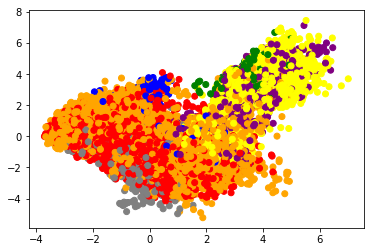

In [7]:
# First, to get a better idea for the data, let's do a PCA of two features and graph it.
# First, use a standard scalar so that no one feature dominates the PCA.

def color(cl):
    if cl == 1:
        return 'red'
    elif cl == 2:
        return 'orange'
    elif cl == 3:
        return 'yellow'
    elif cl == 4:
        return 'green'
    elif cl == 5:
        return 'blue'
    elif cl == 6:
        return 'purple'
    elif cl == 7:
        return 'gray'
    else:
        print('Unknown class', cl)
        exit(1)

ss = sklpp.StandardScaler()
X_pca = ss.fit_transform(X)

pca = skldecomp.PCA(n_components = 2)
pca_points = pca.fit_transform(X_pca)

colors = [color(y_cur) for y_cur in y]
plt.scatter(pca_points[:, 0], pca_points[:, 1], c = colors)
plt.show()

In [8]:
# As you can see, there's a wide degree of overlap between the seven covertypes in the first two elements of the PCA.
# There is a clear pattern/cluster to the colors, though, but several of the colors overlap. It's also still possible
# that the classes are linear in a higher dimension.

In [9]:
# Helper function
def do_multi_label(classifier, classifier_name):
    classifier_ovo = sklmc.OneVsOneClassifier(classifier)
    classifier_ovo.fit(X_tr, y_tr)
    print('"' + classifier_name, 'OVO","', str(classifier_ovo.score(X_te, y_te)) + '"')
    classifier_ovr = sklmc.OneVsRestClassifier(classifier)
    classifier_ovr.fit(X_tr, y_tr)
    print('"' + classifier_name, 'OVR","', str(classifier_ovr.score(X_te, y_te)) + '"')

In [10]:
def exp_list(base, start, end):
    result = []
    accum = base ** start
    for cur in range(end - start):
        result += [accum]
        accum *= base
    return result

In [11]:
# Let's do a 10 cross-fold validation to explore the different models.
ss = sklms.StratifiedKFold(n_splits = 10, shuffle = True)
for train_idx, test_idx in ss.split(X, y):
    X_tr = X[train_idx, :]
    y_tr = y[train_idx]
    y_oh_tr = y_oh[train_idx]
    
    X_te = X[test_idx, :]
    y_te = y[test_idx]
    y_oh_te = y_oh[test_idx]
    
    # Standard scalar, but only fit on the training data.
    ss = sklpp.StandardScaler()
    X_tr = ss.fit_transform(X_tr)
    X_te = ss.transform(X_te)
    
    # What kind of models should we use? Some options we learned in class: tree, svm, bayesian, logistic,
    # k-nearest neighbor, neural network.
    # Should we tweak hyperparameters? Probably.
    
    # Since we have 7 classes, we need a multiclass classifier
    # One-vs-one or one-vs-others? Let's try with both and see what's better.
    
    ### Neural Network ###
    # Different configurations. Changing: layers and neurons per layer.
    # num_layers list will be [2^0 = 1, 2^1 = 2, 2^2 = 4, 2^3 = 8]
    for num_layers in exp_list(2, 0, 4):
        # neurons_per_layer list will be [2^4 = 16, 2^5 = 32, 2^6 = 64, 2^7 = 128, 2^8 = 256]
        for neurons_per_layer in exp_list(2, 4, 9):
            # I used Keras to enable my GPU, otherwise sklearn's MLP takes forever.
            classifier = km.Sequential()
            classifier.add(kl.Dense(units = neurons_per_layer, activation = 'relu', input_dim = X_tr.shape[1]))
            for i in range(num_layers - 1):
                classifier.add(kl.Dense(units = neurons_per_layer, activation = 'relu'))
            classifier.add(kl.Dense(units = y_oh_tr.shape[1], activation = 'softmax'))
            classifier.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'Adam')
            # Go until the loss doesn't change by any meaningful amount.
            classifier.fit(X_tr, y_oh_tr,
                           callbacks = [kc.EarlyStopping(monitor='loss', min_delta = 0.01, verbose=0)],
                           epochs = 1000,
                           verbose = 0)
            print('"MLP (' + str(num_layers) + ', ' + str(neurons_per_layer) + ')","' + str(classifier.evaluate(X_te, y_oh_te, verbose = 0)[1]) + '"')
    
    ### Naive Bayes ###
    # No hyperparameters for Naive Bayes
    classifier = sklnb.GaussianNB()
    do_multi_label(classifier, 'Naive Bayes')    
    
    ### Decision Tree ###
    # Different configurations. Changing: criterion, splitter, and max_depth.
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
            for max_depth in exp_list(2, 1, 7):
                classifier = skltr.DecisionTreeClassifier(criterion = criterion, splitter = splitter, max_depth = max_depth)
                do_multi_label(classifier, 'Decision Tree (' + criterion + ', ' + splitter + ', ' + str(max_depth) + ')')
    
    ### SVM ###
    # Different configurations. Changing: penalty, kernel
    # Scikit-learn's SVM implementation uses one-vs-rest classification under the hood, so we don't need to call
    # do_multi_label here.
    # The different kernel options transform the space to deal better with non-linear classes. Let's see if that helps.
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        classifier = sklsvm.SVC(kernel = kernel)
        classifier.fit(X_tr, y_tr)
        print('"SVM OVR (' + kernel + ')","' + str(classifier.score(X_te, y_te)) + '"')
    
    ### Logistic Regression ###
    # Different configurations. Changing: penalty
    for penalty in ['l2', 'l1']:
        classifier = skllm.LogisticRegression(penalty = penalty)
        do_multi_label(classifier, 'Logistic Regression (' + penalty + ')')

"MLP (1, 16)","0.7309941521698067"
"MLP (1, 32)","0.7313381492127903"
"MLP (1, 64)","0.7368421050376157"
"MLP (1, 128)","0.7426900586025552"
"MLP (1, 256)","0.7450980389901442"
"MLP (2, 16)","0.7285861714336526"
"MLP (2, 32)","0.7488820092104783"
"MLP (2, 64)","0.7671138632121183"
"MLP (2, 128)","0.8073615410256558"
"MLP (2, 256)","0.8145854835826833"
"MLP (4, 16)","0.7337461302975096"
"MLP (4, 32)","0.763673890383333"
"MLP (4, 64)","0.7942896459493843"
"MLP (4, 128)","0.8118335055164918"
"MLP (4, 256)","0.834537323619395"
"MLP (8, 16)","0.7358101134370765"
"MLP (8, 32)","0.7368421051811426"
"MLP (8, 64)","0.7997936015691715"
"MLP (8, 128)","0.8025455797583859"
"MLP (8, 256)","0.8135534913465252"
"Naive Bayes OVO"," 0.09459924320605435"
"Naive Bayes OVR"," 0.13140694874441006"
"Decision Tree (gini, best, 2) OVO"," 0.6831785345717234"
"Decision Tree (gini, best, 2) OVR"," 0.6773305813553492"
"Decision Tree (gini, best, 4) OVO"," 0.7210182318541452"
"Decision Tree (gini, best, 4) OVR"," 

"MLP (1, 32)","0.7591190641285712"
"MLP (1, 64)","0.7615278734885161"
"MLP (1, 128)","0.7749483824924855"
"MLP (1, 256)","0.7732278046653915"
"MLP (2, 16)","0.7584308328418509"
"MLP (2, 32)","0.7677219544126507"
"MLP (2, 64)","0.794907088904896"
"MLP (2, 128)","0.8052305573442436"
"MLP (2, 256)","0.8327598071721859"
"MLP (4, 16)","0.7529249828762624"
"MLP (4, 32)","0.7622161044470622"
"MLP (4, 64)","0.8100481763102643"
"MLP (4, 128)","0.8434273917266442"
"MLP (4, 256)","0.8489332416922326"
"MLP (8, 16)","0.7474191326235216"
"MLP (8, 32)","0.7642807984302886"
"MLP (8, 64)","0.8245010324699339"
"MLP (8, 128)","0.8117687544245106"
"MLP (8, 256)","0.8279421884112742"
"Naive Bayes OVO"," 0.09669649002064694"
"Naive Bayes OVR"," 0.13110805230557468"
"Decision Tree (gini, best, 2) OVO"," 0.6878871300757055"
"Decision Tree (gini, best, 2) OVR"," 0.6724019270474879"
"Decision Tree (gini, best, 4) OVO"," 0.7192016517549896"
"Decision Tree (gini, best, 4) OVR"," 0.7271163110805231"
"Decision Tree

"MLP (1, 64)","0.7584308326777638"
"MLP (1, 128)","0.7632484516437843"
"MLP (1, 256)","0.7697866481497463"
"MLP (2, 16)","0.7487955954841147"
"MLP (2, 32)","0.7629043359799133"
"MLP (2, 64)","0.7842395045555467"
"MLP (2, 128)","0.8038540950169337"
"MLP (2, 256)","0.8231245696503625"
"MLP (4, 16)","0.7460426705013204"
"MLP (4, 32)","0.7752924981153347"
"MLP (4, 64)","0.8011011700751612"
"MLP (4, 128)","0.8337921539586901"
"MLP (4, 256)","0.8375774260561629"
"MLP (8, 16)","0.7374397796839578"
"MLP (8, 32)","0.7611837575785144"
"MLP (8, 64)","0.7955953198634421"
"MLP (8, 128)","0.8310392292220266"
"MLP (8, 256)","0.829318651148802"
"Naive Bayes OVO"," 0.14039917412250516"
"Naive Bayes OVR"," 0.1276668960770819"
"Decision Tree (gini, best, 2) OVO"," 0.692360633172746"
"Decision Tree (gini, best, 2) OVR"," 0.6830695113558155"
"Decision Tree (gini, best, 4) OVO"," 0.7305574673090158"
"Decision Tree (gini, best, 4) OVR"," 0.7302133516861665"
"Decision Tree (gini, best, 8) OVO"," 0.77942188575

"MLP (1, 128)","0.7534435260065988"
"MLP (1, 256)","0.7589531682082773"
"MLP (2, 16)","0.7441460055096418"
"MLP (2, 32)","0.7589531682082773"
"MLP (2, 64)","0.7727272728914728"
"MLP (2, 128)","0.809917355536101"
"MLP (2, 256)","0.8240358126721763"
"MLP (4, 16)","0.7499999998357999"
"MLP (4, 32)","0.7713498620947531"
"MLP (4, 64)","0.7954545452903453"
"MLP (4, 128)","0.8319559227008136"
"MLP (4, 256)","0.8333333331691332"
"MLP (8, 16)","0.744146005673842"
"MLP (8, 32)","0.7706611568605932"
"MLP (8, 64)","0.8112947656760202"
"MLP (8, 128)","0.8226584022038568"
"MLP (8, 256)","0.824724517742136"
"Naive Bayes OVO"," 0.09710743801652892"
"Naive Bayes OVR"," 0.12121212121212122"
"Decision Tree (gini, best, 2) OVO"," 0.6900826446280992"
"Decision Tree (gini, best, 2) OVR"," 0.6804407713498623"
"Decision Tree (gini, best, 4) OVO"," 0.7272727272727273"
"Decision Tree (gini, best, 4) OVR"," 0.7179752066115702"
"Decision Tree (gini, best, 8) OVO"," 0.7558539944903582"
"Decision Tree (gini, best, 

"MLP (2, 16)","0.736479503899823"
"MLP (2, 32)","0.7540475368869334"
"MLP (2, 64)","0.7867723042867203"
"MLP (2, 128)","0.7888391318708874"
"MLP (2, 256)","0.8129521182722524"
"MLP (4, 16)","0.7499138822113691"
"MLP (4, 32)","0.7599035478278846"
"MLP (4, 64)","0.7891836031075391"
"MLP (4, 128)","0.8277643814482772"
"MLP (4, 256)","0.8411987597598235"
"MLP (8, 16)","0.750602824766801"
"MLP (8, 32)","0.767826386599388"
"MLP (8, 64)","0.796761970231749"
"MLP (8, 128)","0.8046848085926107"
"MLP (8, 256)","0.8274199105196068"
"Naive Bayes OVO"," 0.09438511884257665"
"Naive Bayes OVR"," 0.12332070272132277"
"Decision Tree (gini, best, 2) OVO"," 0.68515328970031"
"Decision Tree (gini, best, 2) OVR"," 0.6789528074405787"
"Decision Tree (gini, best, 4) OVO"," 0.7185669996555287"
"Decision Tree (gini, best, 4) OVR"," 0.7175335859455736"
"Decision Tree (gini, best, 8) OVO"," 0.7623148467102997"
"Decision Tree (gini, best, 8) OVR"," 0.7623148467102997"
"Decision Tree (gini, best, 16) OVO"," 0.7733

In [12]:
# Results

# The Naive Bayes classifier was the worst. This is probably because the Naive Bayes works much better for categorical
# data, yet we had a lot of continuous data, like elevation. This is probably a bad application for the Naive Bayes,
# but it's interesting to see the accuracy results for it, anyway.

# What surprised me is the results for the SVM kernels. Even after transforming the space, the kernels ranged 72-76
# accuracy. I thought that it would do much better after the nonlinear transformation, but it only improved by a few
# percentage points. (Maybe a little better than logistic regression.) The kernels did help a little bit, bringing
# accuracy for rbf to 72-76 and poly to 72-75, whereas linear kernel was 70-73, but I expected the improvement to be
# much more pronounced. Maybe the feature space was already mostly linear before the transformation, so the nonlinear
# transformation didn't help that much.

# In addition to being surprised by how little the nonlinear kernels helped the SVM, I'm surprised by how well the
# decision tree performed. Thinking about it more in depth, decision trees have separation boundaries orthogonal to the
# space. If the decision tree depth is unbounded, they can split the space any number of times. This actually turns out
# to be pretty similar to a neural network, except neural network decision boundaries don't necessarily have to be
# orthogonal to the space. Assuming a ReLU, each neuron in the neural network creates another "kink" in the decision
# boundary. Similarly, each layer in a decision tree creates a number of kinks equal to the number of decisions made
# at that level. Thus, we can actually think of an unbounded decision tree as similar to a neural network, except that
# its decisions are constrained to orthogonal hyperplanes.

# Logistic regression performed about as well as the linear SVM. I think this makes sense, because they are pretty
# similar. The SVM follows linear class boundaries whereas the logistic regression follows linear midway probability line.
# The SVM creates stark linear boundaries between the classes, but the logistic regression classifier doesn't create
# boundaries. It creates different degrees of certainty eminating from that line.

# Lastly, the neural network performed the best, as expected. We had to do some tweaks to find out which shape, roughly,
# was the best for it, but the neural network with 4 hidden layers and 256 nodes per layer turned out to be the best,
# achieving an accuracy of 83-85. Any less than that, and there were not enough neurons to learn all the nuances of this
# dataset, but any more than that, and the network started overfitting on the training data.

# Overall, it looks like the neural network approach is probably best for this data, but the decision tree approach also
# looks fruitful, and took much less runtime than the neural network. Decision trees with entropy performed slightly
# better than decision trees with the gini coefficient, and it looks like constraining the depth of the decision tree
# to 32 or 64 is best. One decision tree even managed to break 80% for one of the crossfold validations (entropy, best
# split, 32 max height).